In [ ]:
!pip install wandb

In [ ]:
import wandb

In [ ]:
sweep_config = {
    'method': 'grid',  # or 'random', 'bayes'
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {'values': [5, 10]},
        'batch_size': {'values': [8, 16]},
        'img_height': {'values': [16, 32]},
        'img_width': {'values': [16, 32]},
        'learning_rate': {'values': [0.001, 0.0001]},
        'hidden_units': {'values': [64, 128]}
    }
}

In [ ]:
# Initialize wandb
# wandb.init(project="flowers-classifier-sweep")

# config = wandb.config

# # Use config values
# IMG_HEIGHT = config.img_height
# IMG_WIDTH = config.img_width
# BATCH_SIZE = config.batch_size
# EPOCHS = config.epochs
# LEARNING_RATE = config.learning_rate
# HIDDEN_UNITS = config.hidden_units

def train():
    # Initialize a new wandb run for each sweep configuration
    wandb.init(project="flowers-classifier-sweep")

    # Access sweep configuration
    config = wandb.config

    # Use config values
    IMG_HEIGHT = config.img_height
    IMG_WIDTH = config.img_width
    BATCH_SIZE = config.batch_size
    EPOCHS = config.epochs
    LEARNING_RATE = config.learning_rate
    HIDDEN_UNITS = config.hidden_units

    # Define datasets
    train_dataset = (
        tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
        .map(lambda x: parse_csvline(x, [config.img_height, config.img_width]), num_parallel_calls=tf.data.AUTOTUNE)
        .batch(config.batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    eval_dataset = (
        tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
        .map(lambda x: parse_csvline(x, [config.img_height, config.img_width]), num_parallel_calls=tf.data.AUTOTUNE)
        .batch(config.batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(config.img_height, config.img_width, IMG_CHANNELS)),
        keras.layers.Dense(config.hidden_units, activation="relu"),
        keras.layers.Dense(len(CLASS_NAMES), activation="softmax")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"]
    )

    history = model.fit(
        train_dataset,
        validation_data=eval_dataset,
        epochs=config.epochs,
        callbacks=[WandbCallback()]
    )

    # Finish the wandb run
    wandb.finish()

##Below is code with out using wandb . Run the below code to train the model with out wandb, try it out with different hyper parameters.


Image batch shape: (16, 16, 16, 3)
Label batch shape: (16,)
Labels: [0 1 1 1 0 2 1 0 4 3 0 3 1 4 4 1]


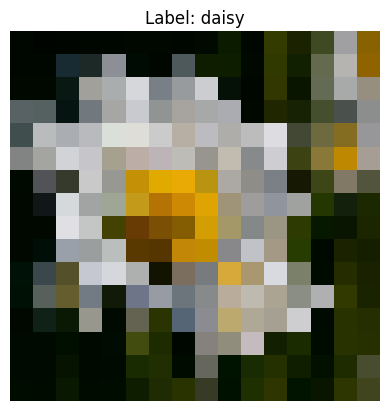

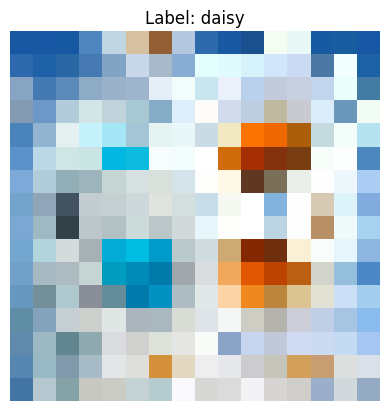

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from wandb.integration.keras import WandbCallback

# Constants
IMG_HEIGHT = 16
IMG_WIDTH = 16
IMG_CHANNELS = 3
CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 0.001
HIDDEN_UNITS = 64

def read_and_decode(filename, resize_dims):
    img_bytes = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, resize_dims)
    return img

def parse_csvline(csv_line, resize_dims):
    record_default = ["", ""]
    filename, label_string = tf.io.decode_csv(csv_line, record_default)

    img = read_and_decode(filename, resize_dims)

    # Convert label string to an integer index
    label = tf.where(tf.equal(CLASS_NAMES, label_string))[0, 0]

    return img, label

# Define datasets
train_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
    .map(lambda x: parse_csvline(x, [IMG_HEIGHT, IMG_WIDTH]), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

eval_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
    .map(lambda x: parse_csvline(x, [IMG_HEIGHT, IMG_WIDTH]), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


for image_batch, label_batch in train_dataset.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)
    print("Labels:", label_batch.numpy())

import matplotlib.pyplot as plt

for image_batch, label_batch in train_dataset.take(2):
     # Take the first image from the batch
     first_image = image_batch[0]
     first_label = label_batch[0]

     # Convert tensor to numpy array
     plt.imshow(first_image.numpy())
     plt.title(f"Label: {CLASS_NAMES[first_label]}")
     plt.axis('off')
     plt.show()

In [2]:
model = keras.Sequential([
     keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
     keras.layers.Dense(HIDDEN_UNITS, activation="relu"),
     keras.layers.Dense(len(CLASS_NAMES), activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
 )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [3]:
history = model.fit(
    train_dataset,
    validation_data=eval_dataset,
    epochs=EPOCHS
)

Epoch 1/5
    207/Unknown 212s 1s/step - accuracy: 0.3357 - loss: 1.5036

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


207/207 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.3360 - loss: 1.5032 - val_accuracy: 0.4378 - val_loss: 1.2727
Epoch 2/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 135s 653ms/step - accuracy: 0.4367 - loss: 1.2771 - val_accuracy: 0.4459 - val_loss: 1.2727
Epoch 3/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 105s 507ms/step - accuracy: 0.4591 - loss: 1.2288 - val_accuracy: 0.4676 - val_loss: 1.2277
Epoch 4/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 91s 440ms/step - accuracy: 0.4837 - loss: 1.1768 - val_accuracy: 0.4946 - val_loss: 1.2005
Epoch 5/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 94s 455ms/step - accuracy: 0.5109 - loss: 1.1413 - val_accuracy: 0.5027 - val_loss: 1.2007


In [ ]:
# sweep_id = wandb.sweep(sweep_config, project="5-flowers-classification")
# wandb.agent(sweep_id, function=train)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:


KeyboardInterrupt: 